In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain_core.documents import Document
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters.character import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, END

In [2]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai.chat_models import ChatGoogleGenerativeAI
import os
model = ChatGoogleGenerativeAI(
                model='gemini-2.0-flash',
                google_api_key=os.getenv('GOOGLE_API_KEY'),
                temperature=0,
                max_output_tokens=1000
            )

model.invoke('Hello')

AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--ea57cff8-b6a1-4842-98ba-9e5a4a7391ad-0', usage_metadata={'input_tokens': 1, 'output_tokens': 10, 'total_tokens': 11, 'input_token_details': {'cache_read': 0}})

In [3]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
import os
embeddings = GoogleGenerativeAIEmbeddings(
    model = 'models/text-embedding-004',
   google_api_key =os.getenv('GOOGLE_API_KEY')
)

embeddings


text="Hello, I am learning about embeddings!"
em = embeddings.embed_query(text)

em

[0.0057954853400588036,
 -0.020777961239218712,
 -0.073767751455307,
 0.005520607344806194,
 0.03836417198181152,
 0.008309532888233662,
 0.05843047797679901,
 0.0198830459266901,
 -0.018817421048879623,
 0.0014214477268978953,
 -0.003038973780348897,
 0.05139459669589996,
 0.0849136933684349,
 -0.017072148621082306,
 0.005389293190091848,
 -0.040984898805618286,
 0.03339604660868645,
 0.023471752181649208,
 -0.10320930182933807,
 0.04719139635562897,
 0.01596192456781864,
 -0.019129928201436996,
 0.011023784056305885,
 -0.025355495512485504,
 -0.03703681007027626,
 -0.008627268485724926,
 0.006926806177943945,
 -0.029250923544168472,
 0.015356908552348614,
 -0.01128516998142004,
 0.04638025164604187,
 0.08751466125249863,
 0.02563812956213951,
 -0.04505224898457527,
 -0.0009145495132543147,
 0.007491415832191706,
 -0.005396759137511253,
 0.015194687992334366,
 0.07375132292509079,
 -0.05054553970694542,
 -0.0762038454413414,
 0.021329674869775772,
 -0.01231074333190918,
 0.06367276608

In [11]:
from langchain_community.document_loaders import WebBaseLoader
import bs4
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/"
]
docs = []
for url in urls:
    docs.extend(WebBaseLoader(url).load())

splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)

vectorstore = FAISS.from_documents(chunks, embeddings)
retriever = vectorstore.as_retriever()


In [12]:
class RAGState(BaseModel):
    question: str
    sub_questions: List[str] = []
    retrieved_docs: List[Document] = []
    answer: str = ""

In [13]:
def plan_query(state: RAGState) -> RAGState:
   
    prompt = f"""
Break the following complex question into 2-3 sub-questions:

Question: {state.question}

Sub-questions:
"""
    result = model.invoke(prompt)
    sub_questions = [line.strip("- ").strip() for line in result.content.strip().split("\n") if line.strip()]
    return RAGState(question=state.question, sub_questions=sub_questions)

## b. Retrieve documents for each sub-question
def retrieve_for_each(state: RAGState) -> RAGState:
    all_docs = []
    for sub in state.sub_questions:
        docs = retriever.invoke(sub)
        all_docs.extend(docs)
    return RAGState(question=state.question, sub_questions=state.sub_questions, retrieved_docs=all_docs)

## c. Generate final answer
def generate_final_answer(state: RAGState) -> RAGState:
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"""
Use the context below to answer the question.

Context:
{context}

Question: {state.question}
"""
    
    answer = model.invoke(prompt).content
    return RAGState(question=state.question, sub_questions=state.sub_questions, retrieved_docs=state.retrieved_docs, answer=answer)


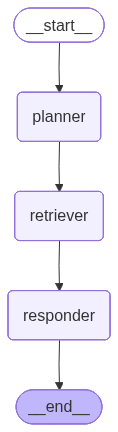

In [14]:
builder = StateGraph(RAGState)

builder.add_node("planner", plan_query)
builder.add_node("retriever", retrieve_for_each)
builder.add_node("responder", generate_final_answer)

builder.set_entry_point("planner")
builder.add_edge("planner", "retriever")
builder.add_edge("retriever", "responder")
builder.add_edge("responder", END)

graph = builder.compile()
graph

In [15]:
if __name__ == "__main__":
    user_query = "Explain how agent loops work and what are the challenges in diffusion video generation?"
    initial_state = RAGState(question=user_query)
    final_state = graph.invoke(initial_state)
    print(final_state)

    print("\n🔍 Sub-questions:")
    for q in final_state['sub_questions']:
        print("-", q)

    print("\n✅ Final Answer:\n", final_state['answer'])

{'question': 'Explain how agent loops work and what are the challenges in diffusion video generation?', 'sub_questions': ['Here are three sub-questions that break down the original question:', '1.  **What is an agent loop and how does it function in the context of AI systems?** (This focuses on defining and explaining the core concept of agent loops.)', '2.  **What is diffusion video generation, and what are the key steps involved in the process?** (This focuses on defining and explaining the core concept of diffusion video generation.)', '3.  **What are the major challenges and limitations currently faced in diffusion video generation?** (This focuses on the difficulties and obstacles in the field.)'], 'retrieved_docs': [Document(id='cb800838-afb0-41ab-8c38-b1e6ddbf23f3', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller i

In [17]:
docs = TextLoader("langchain_sample.txt", encoding="utf-8").load()
chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
vectorstore = FAISS.from_documents(chunks, embeddings)
retriever = vectorstore.as_retriever()

In [18]:
class IterativeRAGState(BaseModel):
    question: str
    refined_question: str = ""
    retrieved_docs: List[Document] = []
    answer: str = ""
    verified: bool = False
    attempts: int = 0

In [19]:
def retrieve_docs(state: IterativeRAGState) -> IterativeRAGState:
    query = state.refined_question or state.question
    docs = retriever.invoke(query)
    return state.model_copy(update={"retrieved_docs": docs})

In [20]:
def generate_answer(state: IterativeRAGState) -> IterativeRAGState:
    
    context = "\n\n".join(doc.page_content for doc in state.retrieved_docs)
    prompt = f"""Use the following context to answer the question:

Context:
{context}

Question:
{state.question}
"""
    response = model.invoke(prompt.strip()).content.strip()
    return state.model_copy(update={"answer": response, "attempts": state.attempts + 1})

In [21]:
def reflect_on_answer(state: IterativeRAGState) -> IterativeRAGState:
    
    prompt = f"""
Evaluate whether the answer below is factually sufficient and complete.

Question: {state.question}
Answer: {state.answer}

Respond 'YES' if it's complete, otherwise 'NO' with feedback.
"""
    feedback = model.invoke(prompt).content.lower()
    verified = "yes" in feedback
    return state.model_copy(update={"verified": verified})

In [22]:
def refine_query(state: IterativeRAGState) -> IterativeRAGState:
    
    prompt = f"""
The answer appears incomplete. Suggest a better version of the query that would help retrieve more relevant context.

Original Question: {state.question}
Current Answer: {state.answer}
"""
    new_query = model.invoke(prompt).content.strip()
    return state.model_copy(update={"refined_question": new_query})

In [48]:
from typing import Literal
def decide_reflection(state: IterativeRAGState)->Literal['refine',END]:
    return END if not state.verified or state.attempts >= 2 else "refine"
    

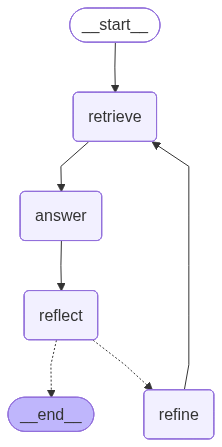

In [49]:
builder = StateGraph(IterativeRAGState)

builder.add_node("retrieve", retrieve_docs)
builder.add_node("answer", generate_answer)
builder.add_node("reflect", reflect_on_answer)
builder.add_node("refine", refine_query)
# builder.add_node("decide_reflection", decide_reflection)
builder.set_entry_point("retrieve")
builder.add_edge("retrieve", "answer")
builder.add_edge("answer", "reflect")
# builder.add_edge("reflect", "decide_reflection")

builder.add_conditional_edges(
    "reflect",
    # lambda s:END if not s.verified or s.attempts >= 2 else "refine"
    decide_reflection
    )

builder.add_edge("refine", "retrieve")
builder.add_edge("answer", END)

graph = builder.compile()
graph

In [40]:
from typing import Literal
from langgraph.graph import StateGraph, END # Make sure END is imported

# ... your node definitions ...

def decide_reflection(state: IterativeRAGState) -> Literal['END','refine']:
    # NOTE: The logic is usually END if verified OR attempts are done. 
    # The original logic below is END if NOT verified. I'll stick to your provided logic:
    if not state.verified or state.attempts >= 2:
        return "END"
    return "refine"

# --- Graph Definition ---
builder = StateGraph(IterativeRAGState)

builder.add_node("retrieve", retrieve_docs)
builder.add_node("answer", generate_answer)
builder.add_node("reflect", reflect_on_answer)
builder.add_node("refine", refine_query)
# ❌ REMOVE: builder.add_node("decide_reflection", decide_reflection) # Not needed as a separate node

builder.set_entry_point("retrieve")
builder.add_edge("retrieve", "answer")
builder.add_edge("answer", "reflect")

# ✅ FIX: Use the function directly in add_conditional_edges
# The function's returned string ("END" or "refine") is used as the next step.
# LangGraph will correctly map the string "END" to the END constant in this context.
builder.add_conditional_edges("reflect", decide_reflection)

builder.add_edge("refine", "retrieve")
# ❌ REMOVE: builder.add_edge("answer", END) # This created an unconditional exit path

graph = builder.compile()
graph

ValueError: At 'reflect' node, 'decide_reflection' branch found unknown target 'END'